In [ ]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import SourceDetectionResult, PyBDSFSourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

import matplotlib.pyplot as plt
# Render plots inline
%matplotlib inline

# Source Detection

## Simulation

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:442: RuntimeWarning: invalid value encountered in log10
  flux = cfun(flux)


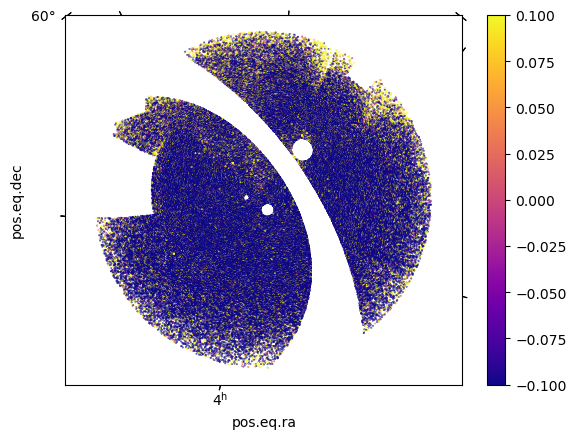

In [8]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.explore_sky(phase_center, s=.1)

Then we filter the sky model based on radius.

In [9]:
sky = gleam_sky.filter_by_radius(0, .5, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

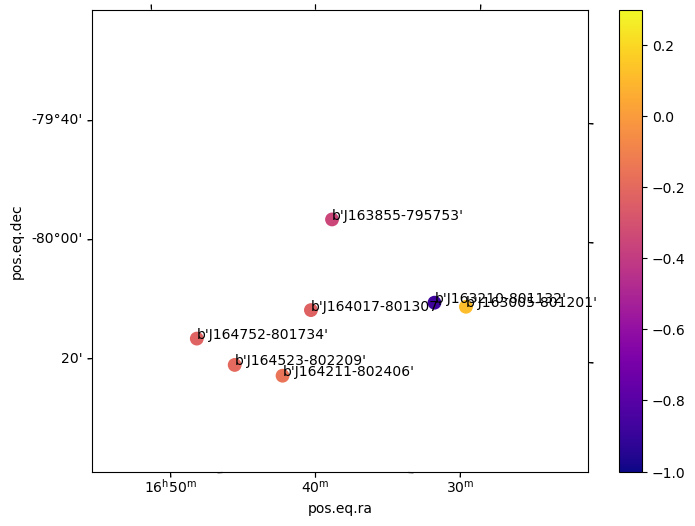

In [10]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246), # RA-lim
    ylim=(-81, -79), # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

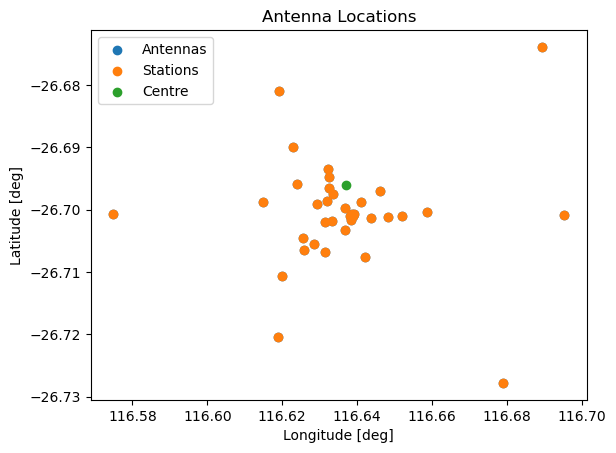

In [11]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [12]:
observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24,
)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)

use_gpu is None, using is_cuda_available() to set use_gpu to True


### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [13]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

{'npixel': 2048, 'cellsize': 3.878509448876288e-05, 'override_cellsize': False}
override_cellsize = False
type override_cellsize = <class 'bool'>
cellsize = 3.878509448876288e-05
cellsize = 3.878509448876288e-05
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  64


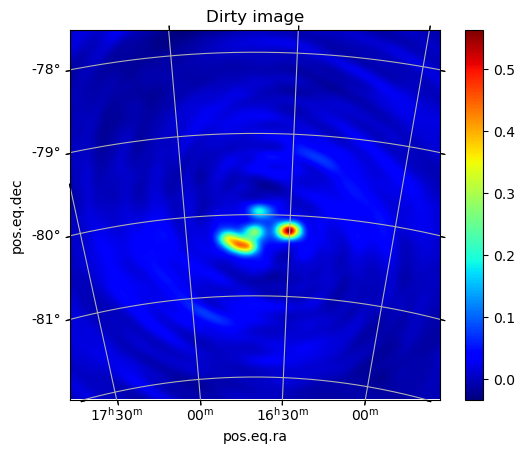

In [14]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel = imaging_npixel,
    imaging_cellsize = imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title='Dirty image')

### Source Detection

In [ ]:
beam_guess = PyBDSFSourceDetectionResult.guess_beam_parameters(imager=imager_askap, method='rascil_1_iter')
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(image=dirty, beam=beam_guess)

In [16]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

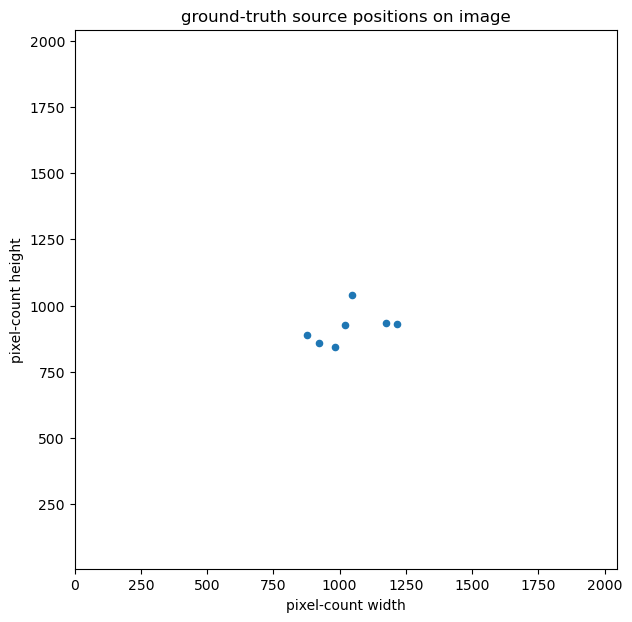

In [17]:
fig, ax = plt.subplots(
    figsize=(7,7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis('equal')
plt.title('ground-truth source positions on image')
plt.xlim((0,imaging_npixel))
plt.ylim((0,imaging_npixel))
plt.xlabel('pixel-count width')
plt.ylabel('pixel-count height')
plt.show()

In [18]:
assignments_dirty = SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
    ground_truth=ground_truth.T,
    detected=detection_result_dirty.get_pixel_position_of_sources().T,
    max_dist=10,
    top_k=3,
)
assignments_dirty

array([[-1.        ,  2.        ,         inf],
       [-1.        ,  4.        ,         inf],
       [ 0.        , -1.        ,         inf],
       [ 1.        , -1.        ,         inf],
       [ 2.        ,  0.        ,  3.5068313 ],
       [ 3.        ,  1.        ,  3.84523062],
       [ 4.        ,  3.        ,  4.68902874],
       [ 5.        , -1.        ,         inf],
       [ 6.        , -1.        ,         inf]])

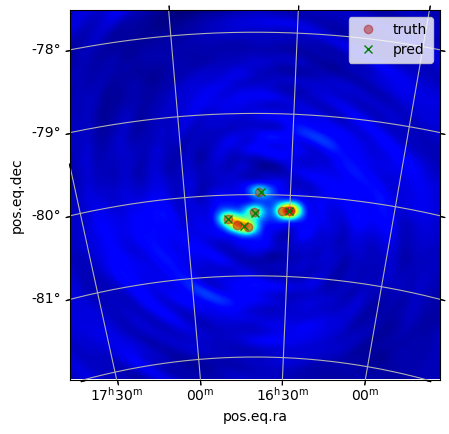

In [19]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [ ]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated',
)

## Analysis via Source Detection

Source Detection on restored image.

In [24]:
detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/234b7c5e-fc49-4282-a042-7ce119fbd91c'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (8.78137e-02, 5.07411e-02, 95.8) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 24.283 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1441, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 5.99e-03 Jy/beam
Value of background mean ................ : 0.00181 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 340
Numb

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [] 1/1[-3G

Total number of Gaussians fit to image .. : 7
Total flux density in model ............. : 5.296 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/09246639-22fb-428c-b868-83e646fbf7e2'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/b531f171-56b9-437e-913f-81cdf27a8cce'


## Evaluation

In [25]:
assignments_restored = SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
    ground_truth=ground_truth.T,
    detected=detection_result.get_pixel_position_of_sources().T,
    max_dist=10,
    top_k=3,
)
assignments_restored

array([[-1.        ,  0.        ,         inf],
       [-1.        ,  4.        ,         inf],
       [ 0.        , -1.        ,         inf],
       [ 1.        ,  5.        ,  6.73621825],
       [ 2.        ,  1.        ,  8.99745885],
       [ 3.        ,  6.        ,  1.75981954],
       [ 4.        ,  2.        ,  3.87447326],
       [ 5.        , -1.        ,         inf],
       [ 6.        ,  3.        ,  1.2261049 ]])

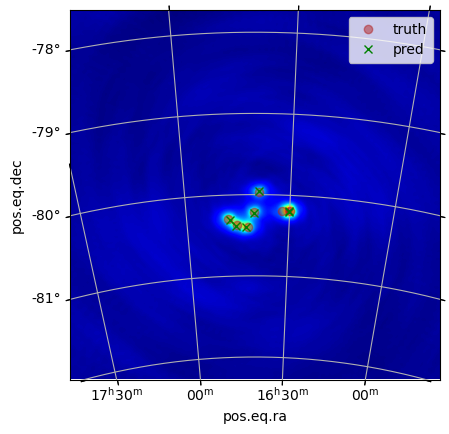

In [26]:
# Create mapping plots
sde_restored = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_restored,
    sky_idxs=sky_idxs,
    source_detection=detection_result,
)
sde_restored.plot()

In [27]:
# Confusion Matrix
sde_restored.get_confusion_matrix()

array([[0., 2.],
       [2., 5.]])

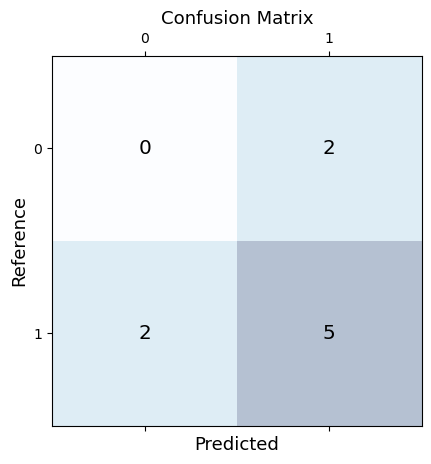

In [28]:
sde_restored.plot_confusion_matrix()

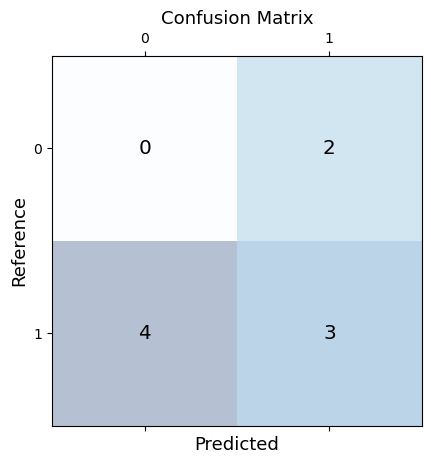

In [29]:
sde_dirty.plot_confusion_matrix()

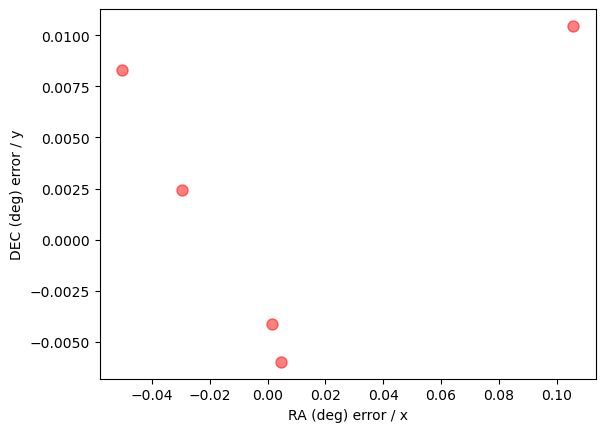

In [30]:
# Plot error ra and dec
sde_restored.plot_error_ra_dec()

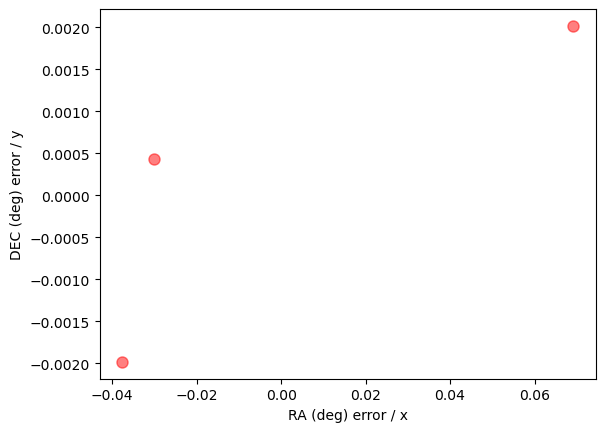

In [31]:
# Plot error ra and dec
sde_dirty.plot_error_ra_dec()

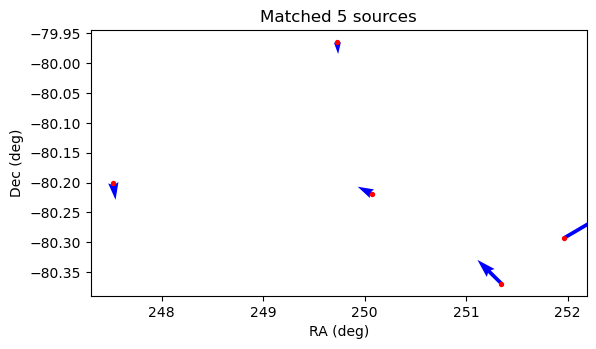

In [32]:
# Plot error flux
sde_restored.plot_quiver_positions()

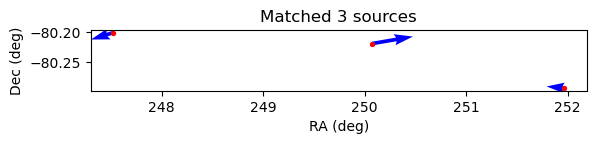

In [33]:
# Plot error flux
sde_dirty.plot_quiver_positions()

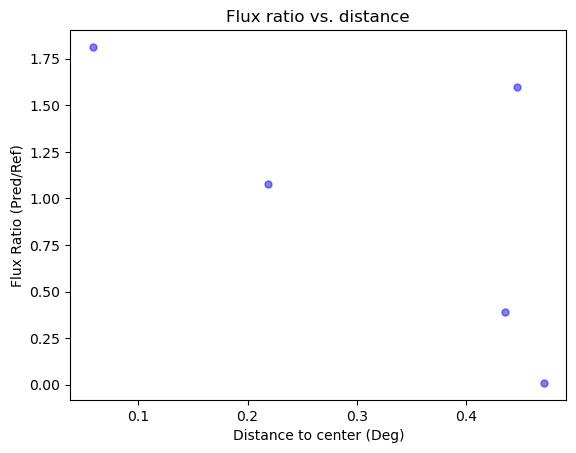

In [34]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_distance()

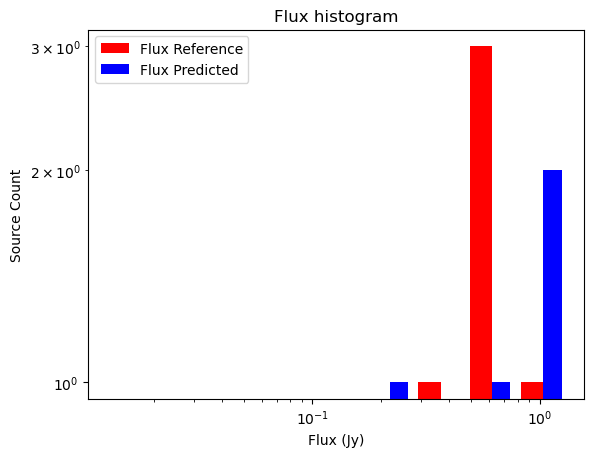

In [35]:
# Plot error ra and dec
sde_restored.plot_flux_histogram()

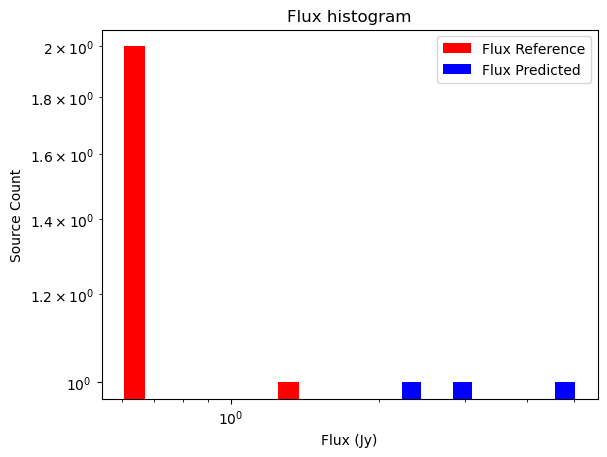

In [36]:
# Plot error ra and dec
sde_dirty.plot_flux_histogram()

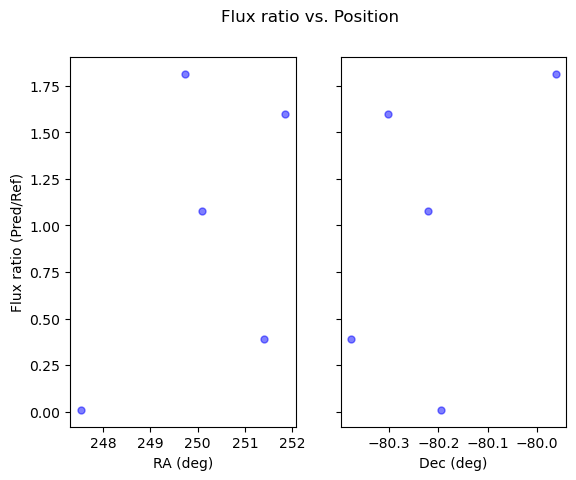

In [37]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_ra_dec()

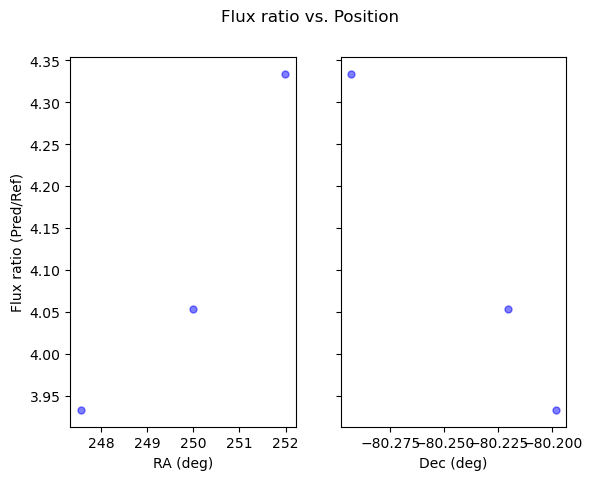

In [38]:
# Plot error ra and dec
sde_dirty.plot_flux_ratio_to_ra_dec()

In [6]:
from karabo.util.FileHandle import FileHandle
# Clean up, if you want to
fh = FileHandle()
fh.clean_up()